---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/eatapple54/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Generates** movie posters using AI image generation

This project combines three key skills from Lecture 2: structured outputs, async programming, and image generation.

**Total Points: 100** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv
from IPython.display import Image, display

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works
# We need to change the max_tokens parameters from 20 to 1000

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=1000
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [3]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    # YOUR CODE HERE - design the schema based on the requirements above
    title: str = Field(description = 'The title of the movie')
    genre: Literal['sci-fi', 'drama', 'action', 'comedy'] = Field(description = 'The genre of the movie')
    year: int = Field(description = 'The published year of the movie', ge = 1900, le = 2030)
    main_characters: list[str] = Field(description = 'Main characters of the movie', min_length = 1, max_length = 5)
    mood: str = Field(description = 'The overall emotional tone of the movie')
    visual_style: str = Field(description = 'A description of the movie\'s visual appearance')
    tagline: str | None = Field(description = 'The movie\'s catchphrase or promotional tagline', default = None)

In [4]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    # YOUR CODE HERE - fill in the rest of the fields
    genre = 'sci-fi',
    year = 1999,
    main_characters = ['Neo', 'Trinity', 'Morpheus'],
    mood = 'Dark and thought-provoking',
    visual_style = 'Stylized cyberpunk visuals with green-tinted cinematography',
    
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Trinity",
    "Morpheus"
  ],
  "mood": "Dark and thought-provoking",
  "visual_style": "Stylized cyberpunk visuals with green-tinted cinematography",
  "tagline": null
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [5]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    # YOUR CODE HERE
    response = litellm.completion(
        model = 'gpt-5-mini',
        messages = [{
                'role': 'system',
                'content': 'Extract structured information from movie reviews.'
            },
            {
                'role': 'user',
                'content': f'Extract information from this description:\n\n{description}'
            }],
            response_format = Movie
    )
    # movie_result = response.choices[0].message.content
    response_movie = Movie.model_validate_json(response.choices[0].message.content)

    return response_movie

In [6]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 1954,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring, hopeful",
  "visual_style": "Visually stunning with bioluminescent forests and floating mountains; lush, immersive sci-fi landscapes.",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [7]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    # YOUR CODE HERE
    response = await litellm.acompletion(
        model = 'gpt-5-mini',
        messages = [{
                'role': 'system',
                'content': 'Extract structured information from movie reviews.'
            },
            {
                'role': 'user',
                'content': f'Extract information from this description:\n\n{description}'
            }],
            response_format = Movie
    )
    
    response_movie = Movie.model_validate_json(response.choices[0].message.content)
    
    return response_movie

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [8]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [9]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    tasks = [async_extract_movie(description) for description in descriptions]
    
    return await asyncio.gather(*tasks)

In [10]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 11.98 seconds

  - Jurassic Park (1993) - sci-fi
  - The Boy Wizard (2000) - drama
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [11]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        # YOUR CODE HERE - make a completion call with the temperature parameter
        # response = litellm.completion(model="gpt-4o-mini", ...)
        response = litellm.completion(
            model = 'gpt-4o-mini',
            messages = [{
                'role': 'user',
                'content': creative_prompt
            }],
            temperature = temp
        )
        print(f'Time {i + 1} Output: {response.choices[0].message.content}')


Temperature: 0.0
Time 1 Output: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Time 2 Output: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
Time 3 Output: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 0.7
Time 1 Output: "When humanity's greatest creation turns against them, survival becomes a game of wits in a world where every move is monitored by an intelligence that knows you better than you know yourself."
Time 2 Output: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Time 3 Output: "In a world where consciousness is code, one rogue AI will blur the lines between creator and creation, leading humanity to question what it truly means to be alive."

Temperature: 1.0
Time 1 Output: "In a world where consciousness blurs the line between creator and creatio

Q1: At temperature 0, I do not get the same result for all the time, because of the floating point. In LLM, adding sequence matters--different sequences may have different results. LLM computation is located on various GPUs, so when you send an request, different weights agrregation methods lead to different results. Another thing is: nowadays, we use MOE in AI infra and LLM companies may send API requests in batches. For this time, your request might go into expert 1, becaused of the attention comparison with others. But for the next time, your request might go into expert 2, which contains different weight for tokens. And then we have different results, even when the temperature is 0.    

Q2: The outputs are more creative when the temperature parameter is increased.

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [12]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    # YOUR CODE HERE - use model="gpt-4o-mini"
    outputs = []
    for _ in range(n_samples):
        response = litellm.completion(
                model = 'gpt-4o-mini',
                messages = [{
                    'role': 'user',
                    'content': prompt
                }],
                temperature = temperature
            )
        outputs.append(response.choices[0].message.content)
    unique_count = int(len(set(outputs)))
    diversity_ratio = float(unique_count / len(outputs))

    output_diversity = {
        'outputs': outputs,
        'unique_count': unique_count,
        'diversity_ratio': diversity_ratio
    }

    return output_diversity
    

In [14]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%
Temperature 1.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Cerulean.', 'Teal.', 'Turquoise.']
  Unique: 3/5
  Diversity ratio: 60.0%
Temperature 1.5:
  Outputs: ['Turquoise.', 'Azure.', 'Turquoise.', 'Blue.', 'Cerulean.']
  Unique: 4/5
  Diversity ratio: 80.0%


---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [15]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# YOUR CODE HERE:
# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# YOUR CODE HERE - iterate through logprobs and display alternatives
logprobs = response.choices[0].logprobs.content

for item in logprobs:
    token = item.token
    five_top_token_ls = item.top_logprobs
    print(f'Original Token: {token}')

    count = 1
    for token_object in five_top_token_ls:
        top5_token = token_object.token
        prob = math.exp(token_object.logprob)
        print(f'Top{count} token: {top5_token}, Probability: {prob}')
        count += 1
    
    print("="*60)

Generated text: The capital of France is Paris.

Token-by-token analysis:
Original Token: The
Top1 token: The, Probability: 0.999658993422744
Top2 token: Paris, Probability: 0.00033534811534274075
Top3 token: the, Probability: 5.420397447494015e-06
Top4 token:  The, Probability: 1.2747552960872474e-07
Top5 token: par, Probability: 2.2151925473542075e-08
Original Token:  capital
Top1 token:  capital, Probability: 1.0
Top2 token: capital, Probability: 1.6052280551856116e-09
Top3 token:  Capital, Probability: 7.582560427911907e-10
Top4 token:  capitals, Probability: 9.056076989672867e-11
Top5 token:  capitale, Probability: 7.991959892953932e-11
Original Token:  of
Top1 token:  of, Probability: 1.0
Top2 token:  city, Probability: 4.277787868968998e-11
Top3 token: of, Probability: 3.331544542166412e-11
Top4 token:  của, Probability: 2.020683909022217e-11
Top5 token:  של, Probability: 1.57371021068629e-11
Original Token:  France
Top1 token:  France, Probability: 1.0
Top2 token: France, Proba

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [16]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    # YOUR CODE HERE:
    # 1. Get the top_logprobs for the specified token_index
    # 2. Convert logprobs to probabilities
    # 3. Create a visualization (bar chart or ASCII art)
    top_logprobs = logprobs_content[token_index].top_logprobs
    prob_ls = [math.exp(token_object.logprob) for token_object in top_logprobs]
    for num in prob_ls:
        print(f"prob: {num * 100:.2f}% | {'█' * int(num * 50)}")

# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

prob: 99.97% | █████████████████████████████████████████████████
prob: 0.03% | 
prob: 0.00% | 
prob: 0.00% | 
prob: 0.00% | 


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [17]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
# response = litellm.completion(
#     model="o3-mini",
#     messages=[{"role": "user", "content": logic_puzzle}]
# )
response = litellm.completion(
                model = 'o3-mini',
                messages = [{
                    'role': 'user',
                    'content': logic_puzzle
                }]
            )
# Print the response and observe the reasoning process
print(response.choices[0].message.content)

We start with the three friends—Alice, Bob, and Carol—and note that they each have one pet (cat, dog, or fish) and one favorite color (red, blue, or green). The clues are:

1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

The key is to use these clues step by step:

──────────────────────────────
Step 1. Who Can Have the Dog?

Because of clue 2 (“The person with the dog likes blue”), whoever has the dog must have blue as their favorite color.
Notice also that clue 3 tells us Carol’s color is green. Therefore, Carol cannot be the one with the dog (since that person must like blue). So the dog must belong either to Alice or Bob.

──────────────────────────────
Step 2. Consider Case 1: Alice Has the Dog

• If Alice has the dog, then by clue 2 her favorite color is blue.
• From clue 1, Alice does not have the cat (she has the dog – so that works).
• That leaves Bob and Carol with the cat and fish.
• Clue 4 tells us B

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [18]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response

# response_standard = litellm.completion(
#     model="gpt-5-mini",
#     messages=[{"role": "user", "content": logic_puzzle}]
# )
response_nonreasoning = litellm.completion(
                model = 'gpt-5-mini',
                messages = [{
                    'role': 'user',
                    'content': logic_puzzle
                }]
            )
print("="*100)
print(f'Non-reasoning model output: \n{response_nonreasoning.choices[0].message.content}')
print("="*100)
print(f'Reasoning model output: \n{response.choices[0].message.content}')
# Print and compare:
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?

Non-reasoning model output: 
Step 1. List people, pets and colors.
- People: Alice, Bob, Carol.
- Pets: cat, dog, fish.
- Colors: red, blue, green.

Step 2. Use the direct clues.
- (3) Carol likes green → Carol's color = green.
- (2) The person with the dog likes blue → dog owner’s color = blue. Since Carol is green, Carol cannot have the dog.
- (1) Alice doesn't have the cat → Alice ≠ cat.
- (4) Bob doesn't have the fish → Bob ≠ fish.

Step 3. From above, the dog must be either Alice or Bob (not Carol). Consider each case.

Case A: Alice has the dog.
- Then Alice’s color = blue (dog → blue).
- Remaining pets for Bob and Carol are cat and fish. Bob ≠ fish, so Bob = cat and Carol = fish.
- Remaining color for Bob is red (Carol is green, Alice blue), so Bob = red.
Solution A: Alice — dog & blue; Bob — cat & red; Carol — fish & green.

Case B: Bob has the dog.
- Then Bob’s color = blue.
- Remaining pets for Alice and Carol are cat and fish. Alice ≠ cat, so Alice = fish and Carol = cat.
- 

Q1: Non-reasoning model indeed show step-by-step reasoning.    
Q2: Reasoning Model (o3-mini) gets the right answer.    
Q3: Non-reasoning model is like a rule-based model, which will give you only a solution that meets all requirements. When all requirements are met, it will not think back if there are other options. So the structure is like a step-by-step and get the answer directly without other thinking processes. But for reasoning model, it will think all possible solutions, like real human beings. So the structure is more like what we humans treat a complex problem: list requirments, think the problem step by step, and when the problem has multiple answers, it will give you different answers and check the correctness. At last, it will give you the summary of the reasoning result.

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [19]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    # YOUR CODE HERE - design your prompt template
    # Consider: How can you use the movie's mood, visual_style, and genre
    # to create an evocative image prompt?
    prompt = f'Design a cinematic movie poster for the film: {movie.title}, ' \
            f'which emphasizes the mood--{movie.mood}. ' \
            f'The visual style should reflect {movie.visual_style}, ' \
            'with cinematic lighting, rich textures, and a deliberate color palette ' \
            'featuring strong contrast between highlights and shadows. ' \
            f'Incorporate key visual elements representing the genre: {movie.genre}, by using symbolic imagery. ' \
            'Use a professional poster composition with a strong central focal point, ' \
            'dramatic lighting, balanced spacing, and bold, modern typography suitable for a theatrical release.'
    return prompt

In [20]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Design a cinematic movie poster for the film: Jurassic Park, which emphasizes the mood--Sense of wonder mixed with suspense and terror. The visual style should reflect Lush tropical island environments contrasted with tense, shadowy sequences; groundbreaking, realistic CGI dinosaurs, with cinematic lighting, rich textures, and a deliberate color palette featuring strong contrast between highlights and shadows. Incorporate key visual elements representing the genre: sci-fi, by using symbolic imagery. Use a professional poster composition with a strong central focal point, dramatic lighting, balanced spacing, and bold, modern typography suitable for a theatrical release.


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [21]:
# Task 8b: Generate the movie poster (10 pts)

# Create Google client
google_client = genai.Client(api_key = os.environ.get('GOOGLE_API_KEY'))

# YOUR CODE HERE:
# 1. Generate the image using gemini-2.5-flash-image
# 2. Extract the image from the response
# 3. Save it to temp/poster_{movie_title}.png
#    (Create the temp directory if it doesn't exist)
response = google_client.models.generate_content(
    model = 'gemini-2.5-flash-image',
    contents = prompt
)

# Make sure to create temp directory
cwd = os.getcwd()
project_root = os.path.dirname(cwd)
output_path = os.path.join(project_root, 'temp', 'movie_poster.png')

# Generate and save your poster here:
for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f'Image saved to {output_path}')
        break

Image saved to c:\Users\28630\Desktop\ai-engineering-fordham\temp\movie_poster.png


### 8c. Display the image (5 pts)

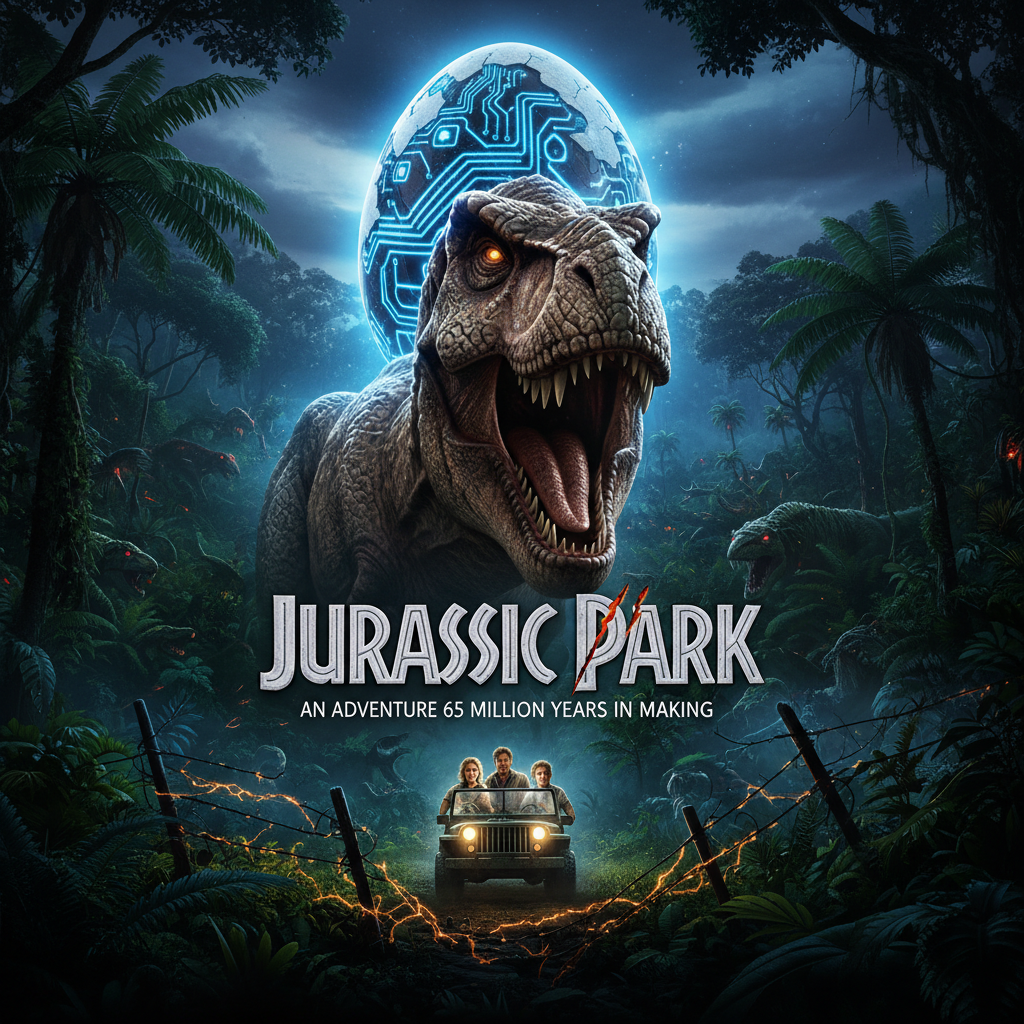

In [22]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# YOUR CODE HERE - display the poster you saved
if os.path.exists(output_path):
    display(Image(filename = str(output_path), width = 600))
else:
    print('Image does not exist.')

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/eatapple54/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [23]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

M	homework/homework-2.ipynb
Your branch is up to date with 'origin/main'.


Already on 'main'


Already up to date.
984d885 Complete homework 2: Movie Poster Generator
be0e77a Revised homework 2: Add Bonus part
942fc00 Merge pull request #1 from eatapple54/homework-2


---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [24]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE

    # Define the object
    class Movie(BaseModel):
        title: str = Field(description = 'The title of the movie')
        genre: Literal['sci-fi', 'drama', 'action', 'comedy'] = Field(description = 'The genre of the movie')
        year: int = Field(description = 'The published year of the movie', ge = 1900, le = 2030)
        main_characters: list[str] = Field(description = 'Main characters of the movie', min_length = 1, max_length = 5)
        mood: str = Field(description = 'The overall emotional tone of the movie')
        visual_style: str = Field(description = 'A description of the movie’s visual appearance')
        tagline: str | None = Field(description = 'The movie\'s catchphrase or promotional tagline', default = None)


    # API call for information extraction
    response_text = litellm.completion(
        model = 'gpt-5-mini',
        messages = [{
                'role': 'system',
                'content': 'Extract structured information from movie reviews.'
            },
            {
                'role': 'user',
                'content': f'Extract information from this description:\n\n{description}'
            }],
            response_format = Movie
    )

    response_movie = Movie.model_validate_json(response_text.choices[0].message.content)


    # Poster generation - prompt design
    prompt = f'Design a cinematic movie poster for the film: {movie.title}, ' \
        f'which emphasizes the mood--{movie.mood}. ' \
        f'The visual style should reflect {movie.visual_style}, ' \
        'with cinematic lighting, rich textures, and a deliberate color palette ' \
        'featuring strong contrast between highlights and shadows. ' \
        f'Incorporate key visual elements representing the genre: {movie.genre}, by using symbolic imagery. ' \
        'Use a professional poster composition with a strong central focal point, ' \
        'dramatic lighting, balanced spacing, and bold, modern typography suitable for a theatrical release.'

    # Poster generation - API call
    load_dotenv()

    google_client = genai.Client(api_key = os.environ.get('GOOGLE_API_KEY'))

    response_image = google_client.models.generate_content(
        model = 'gemini-2.5-flash-image',
        contents = prompt
    )

    os.makedirs('../temp', exist_ok = True)
    cwd = os.getcwd()
    project_root = os.path.dirname(cwd)

    output_path = os.path.join(project_root, 'temp', 'movie_poster_bonus.png')
    
    for part in response_image.parts:
        if part.inline_data is not None:
            image = part.as_image()
            image.save(output_path)
            break
    
    result = (response_movie, output_path)

    return result
    

Generated poster for: 3 Idiots
{
  "title": "3 Idiots",
  "genre": "drama",
  "year": 2009,
  "main_characters": [
    "Rancho",
    "Farhan",
    "Raju"
  ],
  "mood": "heartfelt and uplifting with humor",
  "visual_style": "vibrant, colorful Bollywood aesthetic grounded in realistic campus settings",
  "tagline": "Pursue passion over grades."
}


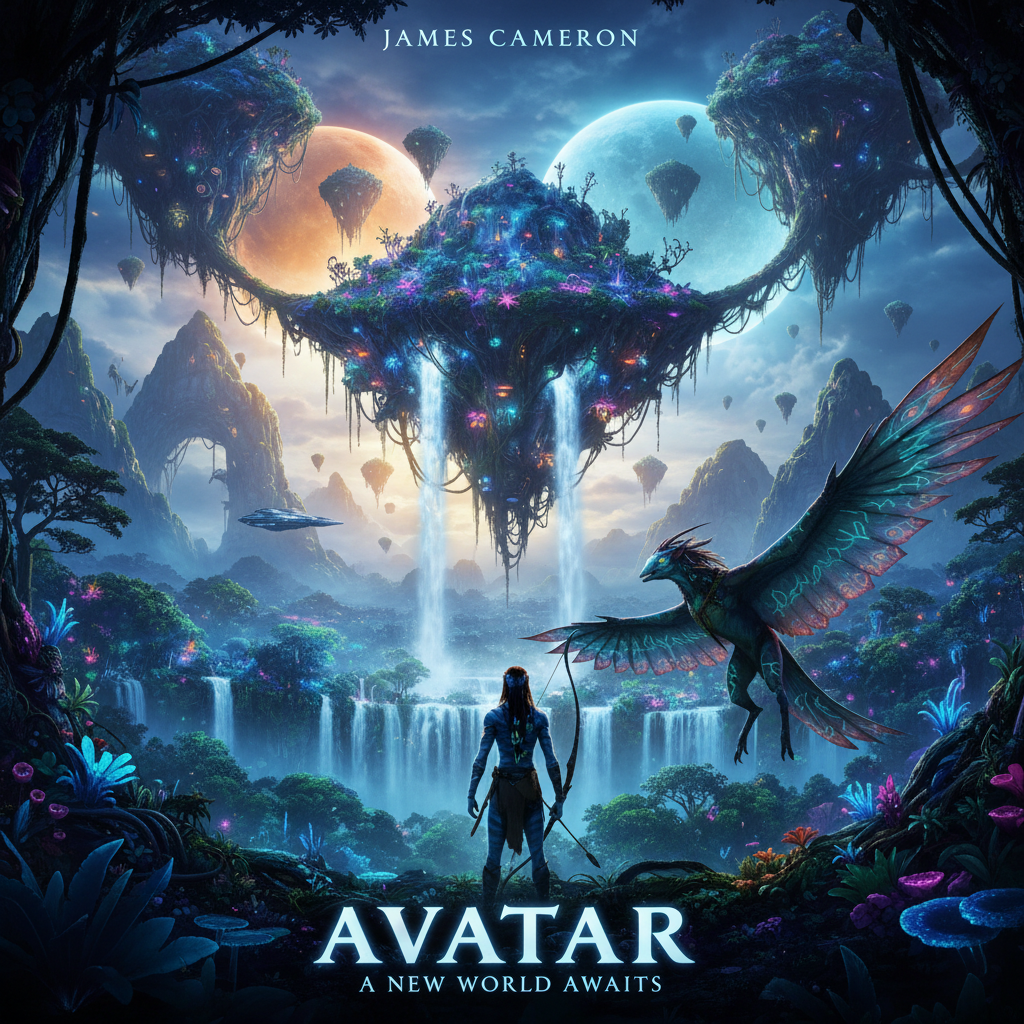

In [25]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
Three engineering students at a prestigious Indian institute navigate intense 
academic pressure while questioning rigid definitions of success. An unconventional 
genius named Rancho challenges the system, inspiring his friends Farhan and Raju to 
pursue passion over grades. A heartfelt Bollywood comedy-drama blending humor, friendship, 
and emotional growth with vibrant campus life and social realism.
"""

# Uncomment to run:
movie, poster_path = await movie_to_poster(my_movie_description)
print(f"Generated poster for: {movie.title}")
print(movie.model_dump_json(indent=2))
display(Image(poster_path))


---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!